In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,12)
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(5)

In [30]:
time_steps = 3
n_features = 1
n_epochs = 100
DATASET = "papas_g2.csv"

In [31]:
def create_dataset(dataset, time_steps=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_steps-1):
		a = dataset[i:(i+time_steps), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_steps, 0])
	return np.array(dataX), np.array(dataY)

In [32]:
data = pd.read_csv('../Data/'+DATASET, engine='python')


In [33]:
model = Sequential()
model.add(LSTM(4, input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

testSets = {}
crops = data["producto"].unique().tolist()
for crop in crops:
    cropData = data[data.producto == crop]["precio_mean"]

    dataset = cropData.values
    dataset = dataset.astype("float32")

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    train = dataset[0 : int(dataset.shape[0] * 0.8), :]
    test = dataset[int(dataset.shape[0] * 0.8) : len(dataset), :]

    trainX, trainY = create_dataset(train, time_steps)
    testX, testY = create_dataset(test, time_steps)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    model.fit(trainX, trainY, epochs=n_epochs, batch_size=1, verbose=2)

    testSets[crop] = {
        "trainX": trainX,
        "trainY": trainY,
        "testX": testX,
        "testY": testY,
        "scaler": scaler,
        "dataset": dataset,
    }


Epoch 1/100
76/76 - 1s - loss: 0.0896 - 853ms/epoch - 11ms/step
Epoch 2/100
76/76 - 0s - loss: 0.0493 - 63ms/epoch - 822us/step
Epoch 3/100
76/76 - 0s - loss: 0.0443 - 62ms/epoch - 816us/step
Epoch 4/100
76/76 - 0s - loss: 0.0410 - 62ms/epoch - 816us/step
Epoch 5/100
76/76 - 0s - loss: 0.0406 - 64ms/epoch - 842us/step
Epoch 6/100
76/76 - 0s - loss: 0.0384 - 64ms/epoch - 842us/step
Epoch 7/100
76/76 - 0s - loss: 0.0367 - 63ms/epoch - 822us/step
Epoch 8/100
76/76 - 0s - loss: 0.0364 - 62ms/epoch - 822us/step
Epoch 9/100
76/76 - 0s - loss: 0.0348 - 62ms/epoch - 816us/step
Epoch 10/100
76/76 - 0s - loss: 0.0342 - 63ms/epoch - 822us/step
Epoch 11/100
76/76 - 0s - loss: 0.0335 - 62ms/epoch - 816us/step
Epoch 12/100
76/76 - 0s - loss: 0.0328 - 62ms/epoch - 822us/step
Epoch 13/100
76/76 - 0s - loss: 0.0324 - 61ms/epoch - 803us/step
Epoch 14/100
76/76 - 0s - loss: 0.0322 - 62ms/epoch - 822us/step
Epoch 15/100
76/76 - 0s - loss: 0.0317 - 60ms/epoch - 789us/step
Epoch 16/100
76/76 - 0s - loss: 0.

1/1 [==============================] - 0s 11ms/step
PAPA BLANCA/VALLE/OTROS
Train Score: 0.13 MAPE
Test Score: 0.10 MAPE


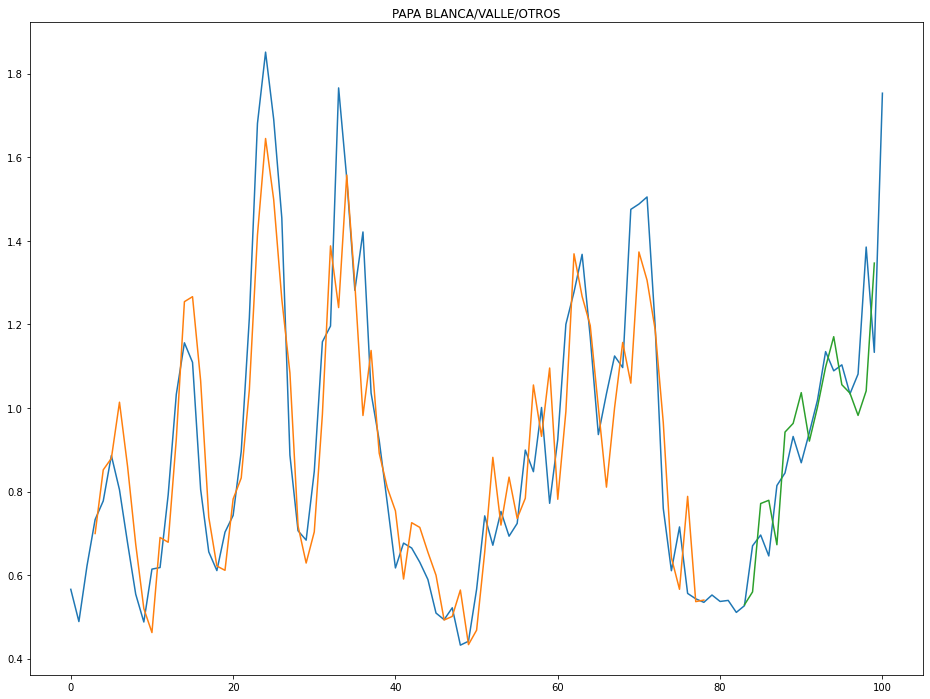

1/1 [==============================] - 0s 10ms/step
PAPA CANCHAN
Train Score: 0.12 MAPE
Test Score: 0.10 MAPE


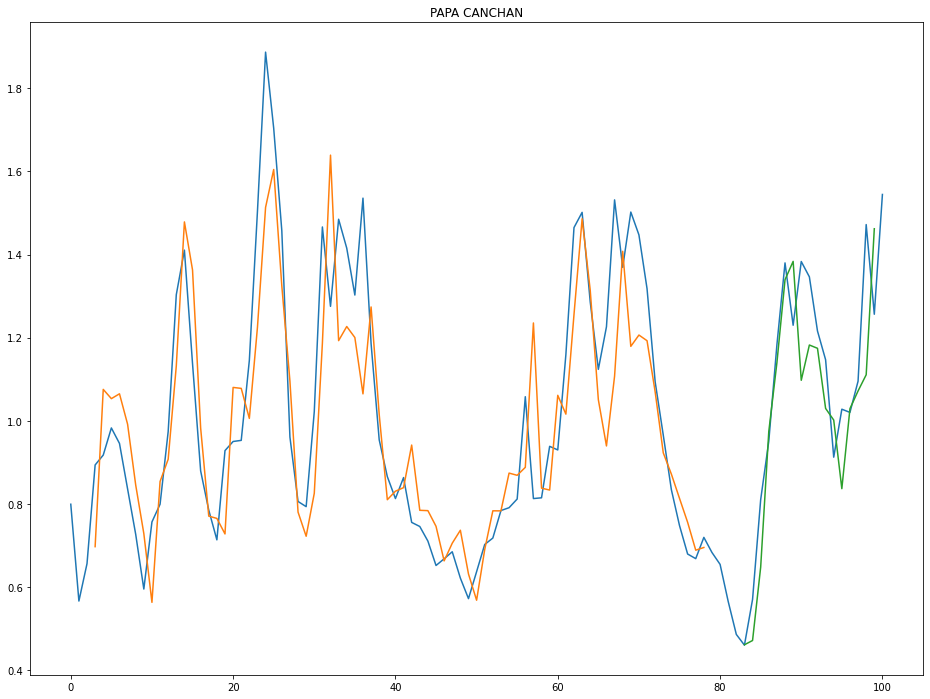

1/1 [==============================] - 0s 10ms/step
PAPA COLOR/VALLE/OTROS
Train Score: 0.13 MAPE
Test Score: 0.11 MAPE


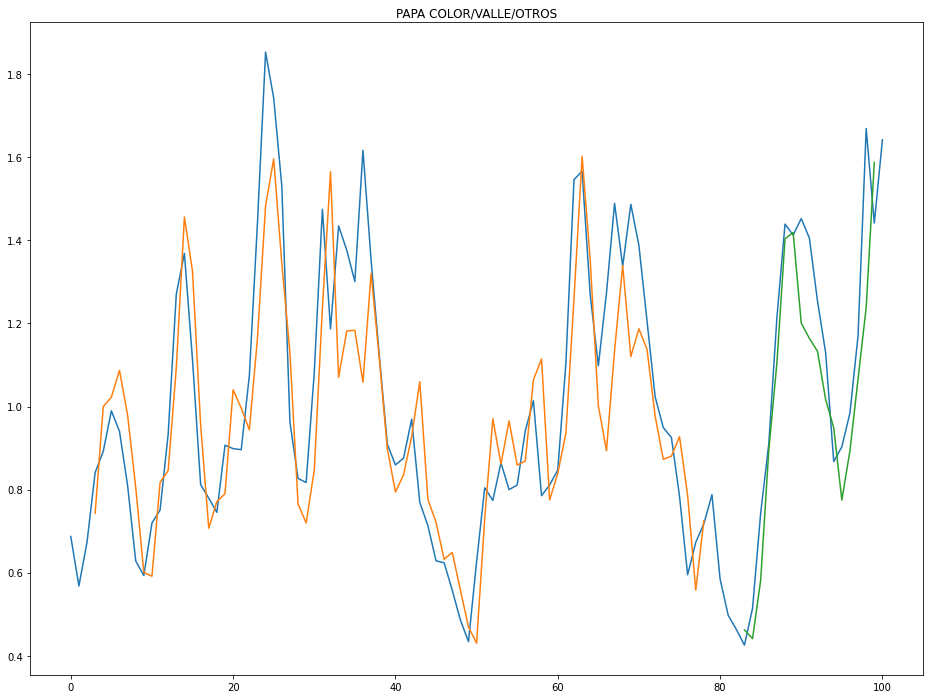

1/1 [==============================] - 0s 10ms/step
PAPA NEGRA ANDINA
Train Score: 0.12 MAPE
Test Score: 0.12 MAPE


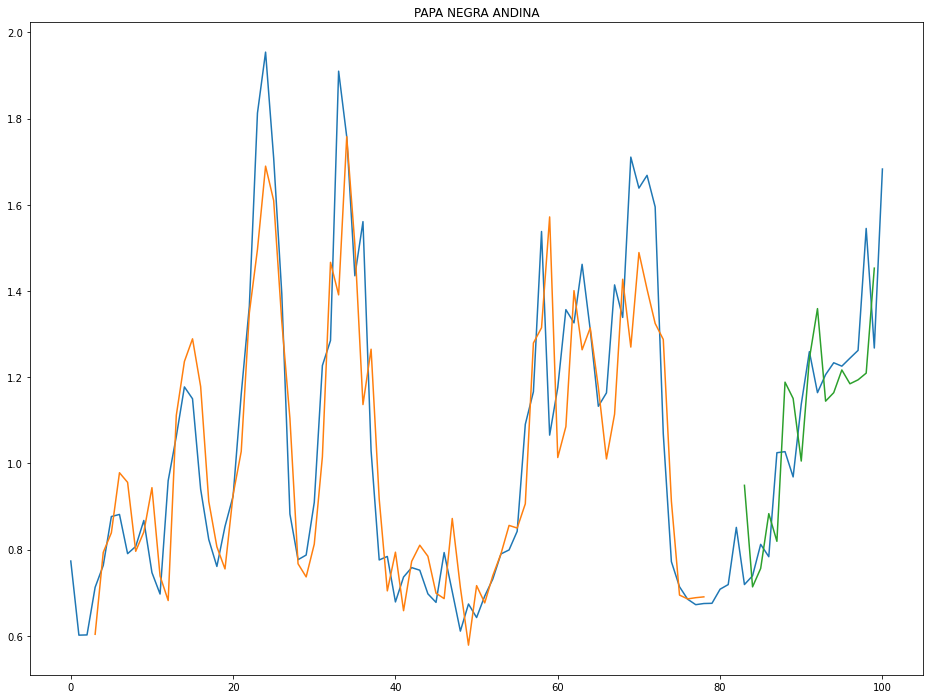

1/1 [==============================] - 0s 10ms/step
PAPA UNICA
Train Score: 0.16 MAPE
Test Score: 0.14 MAPE


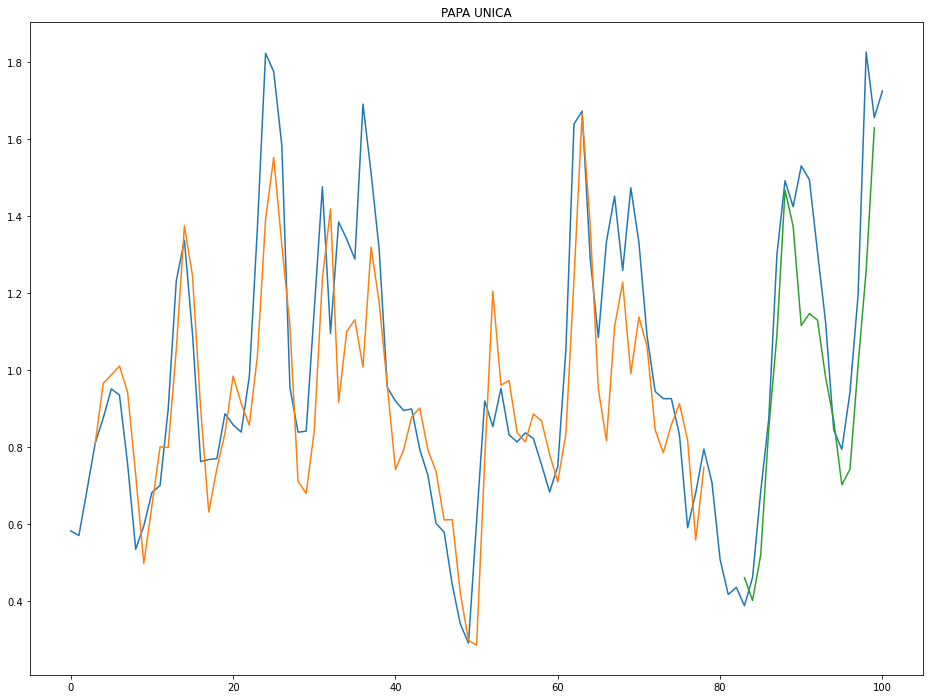

1/1 [==============================] - 0s 11ms/step
PAPA YUNGAY
Train Score: 0.14 MAPE
Test Score: 0.11 MAPE


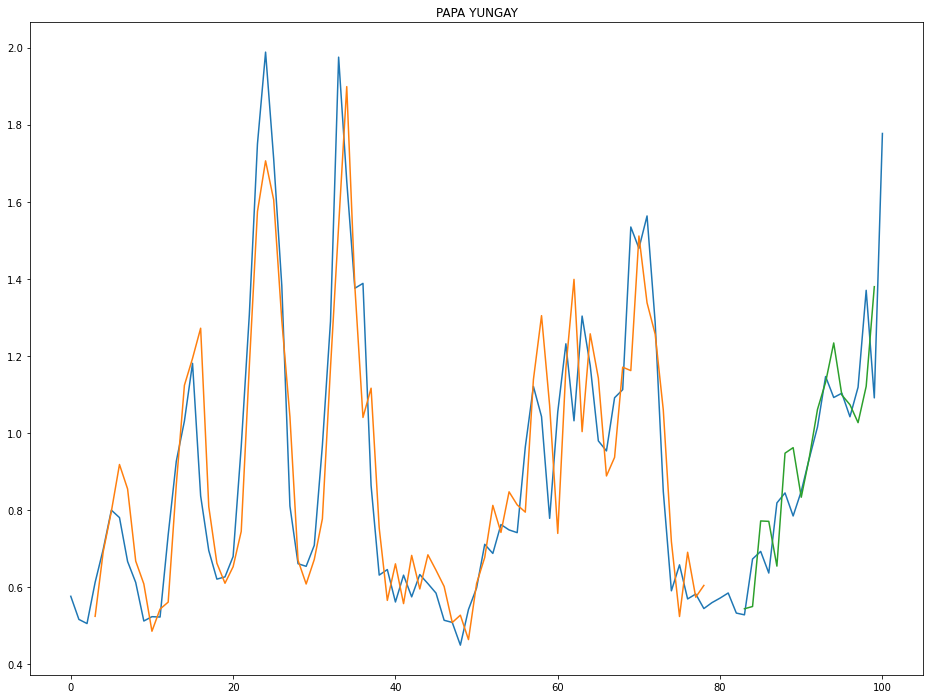

In [34]:
for crop in testSets:
    trainPredict = model.predict(testSets[crop]['trainX'])
    testPredict = model.predict(testSets[crop]['testX'])

    trainPredict = testSets[crop]['scaler'].inverse_transform(trainPredict)
    trainY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['trainY']])
    testPredict = testSets[crop]['scaler'].inverse_transform(testPredict)
    testY = testSets[crop]['scaler'].inverse_transform([testSets[crop]['testY']])
    actualData = testSets[crop]['scaler'].inverse_transform(testSets[crop]['dataset'])
    
    print(crop)
    trainScore = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
    print('Train Score: %.2f MAPE' % (trainScore))
    testScore = mean_absolute_percentage_error(testY[0], testPredict[:,0])
    print('Test Score: %.2f MAPE' % (testScore))

    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict

    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(dataset)-1, :] = testPredict

    plt.title(crop)
    plt.plot(actualData)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [35]:
testX


array([[[0.07935759],
        [0.08794549],
        [0.05408809]],

       [[0.08794549],
        [0.05408809],
        [0.05111811]],

       [[0.05408809],
        [0.05111811],
        [0.14528304]],

       [[0.05111811],
        [0.14528304],
        [0.15807128]],

       [[0.14528304],
        [0.15807128],
        [0.12160078]],

       [[0.15807128],
        [0.12160078],
        [0.23983228]],

       [[0.12160078],
        [0.23983228],
        [0.2567016 ]],

       [[0.23983228],
        [0.2567016 ],
        [0.21781975]],

       [[0.2567016 ],
        [0.21781975],
        [0.25951785]],

       [[0.21781975],
        [0.25951785],
        [0.31530398]],

       [[0.25951785],
        [0.31530398],
        [0.3679245 ]],

       [[0.31530398],
        [0.3679245 ],
        [0.45296997]],

       [[0.3679245 ],
        [0.45296997],
        [0.4176101 ]],

       [[0.45296997],
        [0.4176101 ],
        [0.42480785]],

       [[0.4176101 ],
        [0.42480785],
    